<a href="https://colab.research.google.com/github/csralvall/online_game_toxicity/blob/main/clustering_w2v.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Import utility functions

In [1]:
from IPython.display import clear_output

### Install dependencies

In [2]:
# install dependencies
!pip install -U pip setuptools wheel pandas sklearn numpy gensim wget
clear_output()

### Import libraries

In [3]:
# import libraries
from google.colab import drive
import pandas as pd
import numpy as np
import sklearn.manifold
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize
from sklearn.cluster import KMeans
from collections import Counter
from gensim.models import Word2Vec

### Setup dataframe print options

In [4]:
pd.set_option("display.max_rows", None, "display.max_columns", None)

### Mount storage

In [5]:
# mount google drive unit to save computationally expensive results
drive.mount('/content/drive')

Mounted at /content/drive


### Load subset of whole dataset from storage

In [10]:
# english chats from original dataset with anotations
eng_annotated = '/content/drive/MyDrive/nlp/dota2_chat_eng_annotated.csv'
df_test = pd.read_csv(eng_annotated)[:10000]

In [ ]:
df_test.head()

,match,time,slot,text,language,clean,tokens,intensity,toxicity
0,0,1808.40822,9,100%,en,100,NaN,0,0
1,1,-131.14018,0,twitch.tv/rage_channel,en,twitch rage channel,twitch rage channel,0,0
2,1,-121.60481,0,https://www.twitch.tv/rage_channel,en,https www twitch rage channel,https www twitch rage channel,0,0
3,1,700.72893,0,https://www.twitch.tv/rage_channel,en,https www twitch rage channel,https www twitch rage channel,0,0
4,1,702.99503,0,https://www.twitch.tv/rage_channel,en,https www twitch rage channel,https www twitch rage channel,0,0


### Get bad word list from memory

In [11]:
# get downloaded bad word list
word_list = "/content/drive/MyDrive/nlp/bad_words.txt"
# use set for fast queries
bad_words = set(line.strip() for line in open(word_list, 'r'))
# add new bad words
bad_words.update(['noob', 'noobs', 'stfu', 'fukign', 'fuking', 'fukin', 'nooob'])
bad_dict = dict.fromkeys(bad_words, 0)

### Word2Vec embeddings:

In [ ]:
# function to create embeddings of words in each chat
def generate_embedding_w2v(sentences: [[str]]):
  w2v_model = Word2Vec(
                     min_count=20,
                     window=2,
                     #size=300,
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20,
                     workers=1)

  w2v_model.build_vocab(sentences, progress_per=10000)

  w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)

  return w2v_model

### Unroll chats as list of words

In [12]:
def flatten(t):
    return [item for sublist in t for item in sublist]

In [13]:
# from cleaned english chats get all of them without nan values
chats = df_test[['tokens']].dropna().astype(str).values
chats = flatten(chats)
vocab = list(map(lambda x: x.split(), chats))

### Generate word embeddings from chat

In [ ]:
w2v_model = generate_embedding_w2v(vocab)

In [ ]:
# save Word2Vec model
w2v_model.save('/content/drive/MyDrive/nlp/word2vec.model')

### Load word embeddings from disk

In [6]:
# load Word2Vec model
w2v_model = Word2Vec.load('/content/drive/MyDrive/nlp/word2vec.model')

### Embeddings utils

In [7]:
# generate embedding from chat
def chat_embedding(model, chat_words):
    chat_embedding = np.ones(100)
    for word in chat_words:
        if word in model.wv:
            chat_embedding *= model.wv[word] 
    return chat_embedding

### Clustering utils

In [8]:
def get_bad_vec(lexicon, chat_words):
    for word in chat_words:
        if word in lexicon:
            bad_dict[word] += 1

    bad_vec = np.fromiter(bad_dict.values(), dtype=int)
    
    return bad_vec

In [14]:
intensity = df_test[['intensity']].copy()

### Create w2v vectors for clustering

In [ ]:
w2v_serie = np.array([])
for idx, chat in enumerate(chats):
    lexicon = dict.fromkeys(bad_words, 0)
    chat_intensity = intensity.loc[idx]
    chat_words = chat.split()
    bad_vec = get_bad_vec(lexicon, chat_words)
    w2v_embedding = chat_embedding(w2v_model, chat_words)
    w2v_bad_int_vec = np.hstack((w2v_embedding, bad_vec, chat_intensity)).ravel()
    w2v_serie = np.concatenate((w2v_serie, w2v_bad_int_vec))

### Reshape data

In [15]:
w2v_ncolumns = w2v_model.wv.vectors.shape[1] + len(bad_words) + 1
w2v_serie = w2v_serie.astype('float').reshape((-1, w2v_ncolumns))
w2v_matrix = w2v_serie[~np.isnan(w2v_serie)].reshape((-1, w2v_ncolumns))

NameError: ignored

### Matrix reduction

In [ ]:
def reduce_matrix(matrix: np.ndarray, *, variance_treshold: float):
    print(f'INPUT SHAPE: {matrix.shape}')
    # reduce all vectors to [0, 1] space
    normalized_matrix = normalize(matrix, axis=1)
    # compute variances in each row
    matrix_variances = np.var(matrix, axis=0)
    # create mask for features with high correlation (low variance)
    bool_mask = np.where(matrix_variances < variance_treshold)
    # filter features with high correlation (variance under treshold)
    raked_matrix = np.delete(normalized_matrix, bool_mask, axis=1)
    print(f'OUTPUT SHAPE: {raked_matrix.shape}')
    return raked_matrix

### Reduce matrix

In [ ]:
w2v_reduced = reduce_matrix(w2v_matrix, variance_treshold=0.01)

INPUT SHAPE: (8157, 1492)
OUTPUT SHAPE: (8157, 239)


### Save matrix

In [ ]:
with open('/content/drive/MyDrive/nlp/w2v_serie_10000.npy', 'wb') as output_file:
    np.save(output_file, w2v_reduced)

### Load matrix from storage

In [16]:
w2v_reduced = np.load('/content/drive/MyDrive/nlp/w2v_serie_10000.npy')

### Clustering

In [ ]:
def generate_clusters(
    matrix: np.ndarray,
    n_clusters: int
) -> KMeans:
    # generate word clusters using the KMeans algorithm.
    print("\nClustering started")
    # Instantiate KMeans clusterer for n_clusters
    km_model = KMeans(n_clusters=n_clusters, random_state=3)
    # create clusters
    km_model.fit(matrix)
    print("Clustering finished")
    return km_model

### Create clusters

In [17]:
w2v_clusters = generate_clusters(w2v_reduced, 40)

NameError: ignored

### Cluster utility functions

In [ ]:
def display_summary(clusters: KMeans):
    cluster_count = Counter(sorted(clusters.labels_))
    for cluster in cluster_count:
        print ("Cluster#", cluster," - Total words:", cluster_count[cluster])

In [ ]:
def annotate_dataframe(clusters: KMeans, df: pd.DataFrame, col_name: str):
    cluster_count = Counter(sorted(clusters.labels_))
    #sort cluster centers by proximity to centroid
    order_centroids = clusters.cluster_centers_.argsort()[:, ::-1] 

    clusters_df = np.zeros(len(df))
    
    for cluster_idx in cluster_count:
        # get words inside each cluster
        cluster_words = np.where(clusters.labels_ == cluster_idx)[0]
        # anotate all chats in cluster
        for idx in cluster_words:
            clusters_df[idx] = int(cluster_idx)

    df[col_name] = clusters_df

### Show info about clusters

In [ ]:
# show number of words captured by each cluster
display_summary(w2v_clusters)

Cluster# 0  - Total words: 118
Cluster# 1  - Total words: 408
Cluster# 2  - Total words: 121
Cluster# 3  - Total words: 151
Cluster# 4  - Total words: 369
Cluster# 5  - Total words: 8
Cluster# 6  - Total words: 317
Cluster# 7  - Total words: 43
Cluster# 8  - Total words: 1131
Cluster# 9  - Total words: 758
Cluster# 10  - Total words: 6
Cluster# 11  - Total words: 67
Cluster# 12  - Total words: 96
Cluster# 13  - Total words: 311
Cluster# 14  - Total words: 1
Cluster# 15  - Total words: 434
Cluster# 16  - Total words: 2
Cluster# 17  - Total words: 50
Cluster# 18  - Total words: 53
Cluster# 19  - Total words: 3
Cluster# 20  - Total words: 11
Cluster# 21  - Total words: 737
Cluster# 22  - Total words: 69
Cluster# 23  - Total words: 398
Cluster# 24  - Total words: 3
Cluster# 25  - Total words: 8
Cluster# 26  - Total words: 83
Cluster# 27  - Total words: 28
Cluster# 28  - Total words: 2
Cluster# 29  - Total words: 1
Cluster# 30  - Total words: 15
Cluster# 31  - Total words: 664
Cluster# 32  

### Annotate cluster for each row in dataframe

In [ ]:
df_test = df_test.copy()

In [ ]:
annotate_dataframe(w2v_clusters, df_test, 'w2v_clusters')

In [ ]:
df_test.to_csv(f'/content/drive/MyDrive/nlp/w2v_clusters_df.csv', index=False)

### Load FastText clusters

In [21]:
df_test = pd.read_csv('/content/drive/MyDrive/nlp/w2v_clusters_df.csv')

### Explore results

In [22]:
w2v_group = df_test.groupby('w2v_clusters')

#### Get toxicity score for each cluster

In [27]:
w2v_score = (w2v_group['toxicity'].sum() / w2v_group.size())
w2v_scored = pd.DataFrame({'score': w2v_score.values, 'size': w2v_group.size()})
w2v_scored = w2v_scored[w2v_scored['score'] > 0.13]
w2v_scored = w2v_scored.sort_values(by=['score', 'size'], ascending=[False, False])
top_toxic_clusters = w2v_scored.index.to_list()
w2v_scored

,score,size
w2v_clusters,,
19.0,0.333333,3
25.0,0.250000,8
36.0,0.250000,8
37.0,0.185629,167
26.0,0.180723,83
13.0,0.138264,311
1.0,0.134804,408
23.0,0.130653,398


### Explore clusters

In [53]:
w2v_group.get_group(19)[['match','text']]

,match,text
23,6,figures
24,6,fucking reported axe
25,6,why axe is raping me top


In [52]:
w2v_group.get_group(25)[['match','text']]

,match,text
26,6,sorry nex
29,6,ur not even a good hooker kid
39,6,what is the best soup?
41,6,I guess
48,9,dont roam mid more
54,9,free farming ls
56,9,let end
79,9,I PLAY LEGACY


In [51]:
w2v_group.get_group(36)[['match','text']]

,match,text
15,3,vac d o l b a e b
16,4,wtf
19,5,ebat'
21,6,report
22,6,so ya mama likes dick ehh?
44,8,not defending
64,9,cant seem to hit a singel call
94,9,WER R U OD


In [50]:
w2v_group.get_group(37)[['match','text']]

,match,text
776,115,wp
777,115,moron
779,115,Whats wrong?
780,115,Que?
781,115,Que?
783,115,lol
784,115,their 2 stack was perfect aparently
785,115,2-9 2-10
786,115,pro tier plays
788,115,boring ass game


In [49]:
w2v_group.get_group(26)[['match', 'text']]

,match,text
687,107,dun use small id to lie other ppl
688,107,u still injoler
689,107,me?
690,107,lol
691,107,take so long time to end
692,107,noob
693,107,Lol
694,107,i fuck your mum
695,107,she so hot
696,107,end pls


In [39]:
w2v_group.get_group(13)['text']

1439                                                  how
1440                                           am is fine
1446                                    oh u really there
1448                                                gg wp
1449                                                gg wp
1450                                                  1 0
1452                                         good game :S
1453                                  fantastic feed fest
1454                                                  wtf
1455                                               Really
1456                          this is jsut stupid, im out
1457                                                yanga
1458                                               yganda
1459                                                  wtf
1460                                         5-5 only mid
1461                                                  wtf
1462                                                  10*
1463          

In [48]:
w2v_group.get_group(1)[['match','text']]

,match,text
3489,506,XDD
3490,506,pushh and end lmao
3491,506,stopunder lord?
3492,506,playing carry
3493,506,my farm
3494,506,is guaranteeed
3495,506,XD
3496,506,XD
3497,506,and quillsprayu
3498,506,u r archon


In [47]:
w2v_group.get_group(23)[['match','text']]

,match,text
1762,235,can only farm and do noting
1763,235,like creep
1764,235,end
1765,235,cant believe how alch can have item
1766,235,unbelievable
1767,235,Team can feed every noob
1768,235,And let me die to ward
1769,235,best team
1770,235,easy gyro
1771,235,cant 1on5


### Reduce dimensionality to display data

In [42]:
# use TSNE to reduce dimensionality of data
tsne = sklearn.manifold.TSNE(n_components=2, random_state=0)
matrix_dicc2d = tsne.fit_transform(w2v_reduced)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


### Display data without clusters

In [43]:
pointsspacy = pd.DataFrame(
    [(chat, coord[0], coord[1]) for (chat, coord) in zip(chats, matrix_dicc2d)],
    columns=["word", "x", "y"]
)

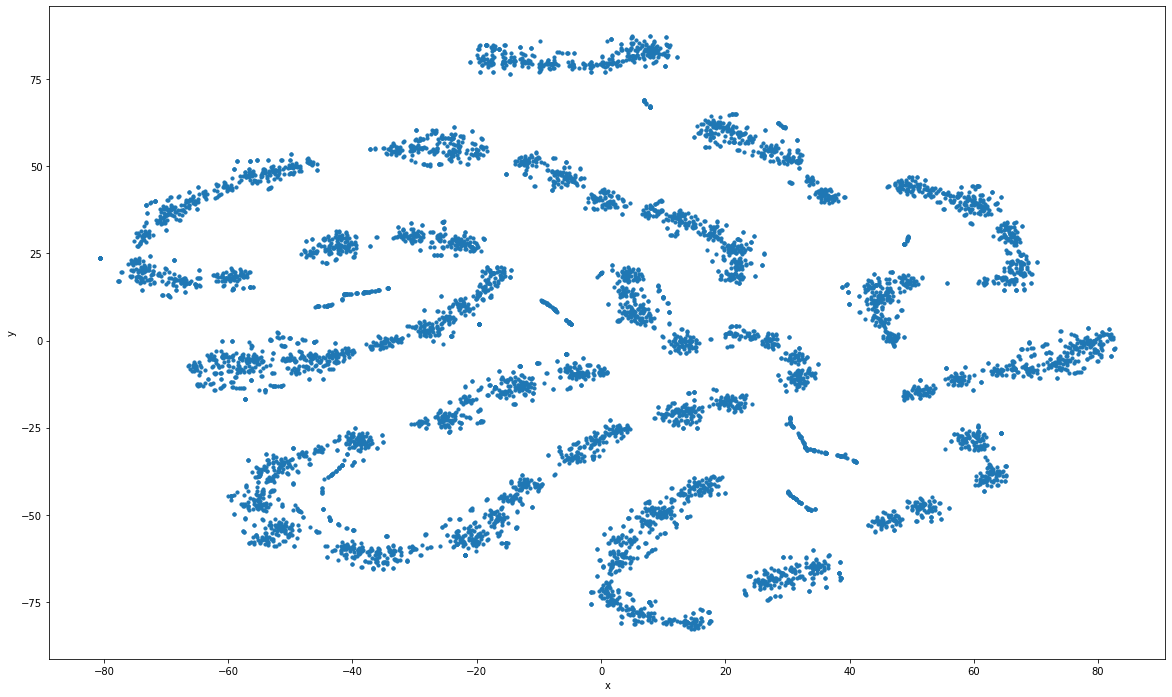

In [44]:
pointsspacy.plot.scatter("x", "y", s=10, figsize=(20, 12))

### Display clusters and clusters with biggest proportion of toxic words

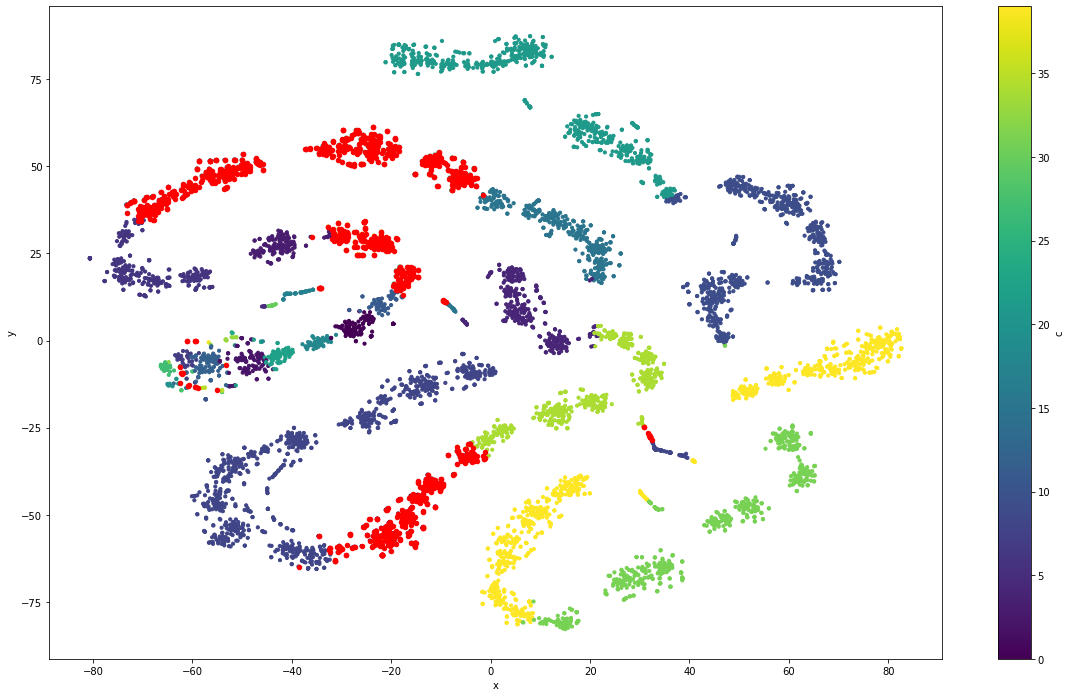

In [46]:
fig, ax = plt.subplots()
pointscluster = pd.DataFrame(
    [(chat, coord[0], coord[1], cluster) for (chat, coord, cluster) in zip(df_test['clean'], matrix_dicc2d, df_test['w2v_clusters']) ],
    columns=["word", "x", "y", "c"]
)
pointscluster.plot(ax=ax, kind='scatter', x='x', y='y', c='c', cmap='viridis', s=10, figsize=(20, 12))
toxic_clusters = pd.DataFrame(
    [(coord[0], coord[1]) for (coord, cluster) in zip(matrix_dicc2d, df_test['w2v_clusters']) if cluster in top_toxic_clusters ],
    columns=["x", "y"]
)
toxic_clusters.plot(ax=ax, kind='scatter', x='x', y='y', color='red')
plt.show()